In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Fast Fourier Transform (FFT)

### Discrete Fourier Transform

Let $x_j = \frac{2\pi j}{n}$ for $j=0,\dots,n-1$ and let $f_j = f(x_j)$ be the sampled function values.


Consider the DFT 
$$ y_k = \sum_{j=0}^{n-1} f_j \exp\left(-\frac{2\pi ijk}{n}\right) = \sum_{j=0}^{n-1} f_j \omega_n^{jk} \qquad k =0,\dots,n-1, $$

A naive implementation of this algorithm this requires O$(n^2)$ flops. 

### Naive implementation

In [2]:
import numpy as np
def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return M @ x 

In [3]:
x = np.random.random(1024)
np.allclose(DFT_slow(x), np.fft.fft(x))

True

### Some remarks:
+ We have defined, in lecture, $\omega_n = \exp(2\pi i/n)$ but here we use $\omega_n = \exp(-2\pi i/n)$. This change of notation will make it consistent with standard descriptions of the FFT algorithm.
+ For simplicity, consider $n=2^p$ as a power of $2$. We will discuss the general case later.

## Two-level algorithm and recursion

### Split into even and odd terms

We can split the sum as 
$$ y_k = \underbrace{\left(\sum_{l=0}^{n/2-1} f_{2l} \omega_n^{2lk}\right)}_\text{Even terms} + \underbrace{\left(\sum_{l=0}^{n/2-1} f_{2l+1} \omega_n^{2lk} \right)}_\text{Odd terms} \omega_n^k \qquad k =0,\dots,n-1 $$
where we have used the fact that the odd terms can be written as $\omega_n^{(2l+1)k} = \omega_n^{2lk} \omega_n^k $.

### Two DFTs of size n/2

We have written 
$$ y_k = E_k + \omega_n^k O_k \qquad k=0,\dots,n/2-1, $$


where using the fact that $\omega_n^{2jk} = \omega_{n/2}^{jk}$

$$  E_k =  \> \sum_{j=0}^{n/2-1} \omega_{n/2}^{jk} f_{2j} \qquad  O_k =  \> \sum_{j=0}^{n/2-1} \omega_{n/2}^{jk} f_{2j+1}.  $$

Similarly using the cyclic property of $\omega_n$ we have $$ y_{k+n/2} =E_k - \omega_n^k O_k  \qquad k=0,\dots,n/2-1. $$

These relations are called as the **Butterfly relations** and were observed by Danielson and Lanczos.

### Summary so far

We have written the DFT with $n$ terms as 
+ Two DFTs of size $n/2$ each -- $  E_k =  \> \sum_{j=0}^{n/2-1} \omega_{n/2}^{jk} f_{2j}$ and $O_k =  \> \sum_{j=0}^{n/2-1} \omega_{n/2}^{jk} f_{2j+1}$.
+ $E_k$ works with even indices of $f$, $O_k$ works with the odd indices of $f$
+ Additional O$(n)$ cost to piece everything back together.
$$ y_k = E_k + \omega_n^k O_k \qquad y_{k+n/2} =E_k - \omega_n^k O_k \quad  k=0,\dots,n/2-1. $$

Key idea: apply this idea recursively.

In [4]:
def FFT(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N == 1:
        return x
    else:
        X_even = FFT(x[::2])   #Even terms
        X_odd = FFT(x[1::2])   #Odd terms
        factor = np.exp(-2j * np.pi * np.arange(N/2)/ N)
        y = np.zeros((N,), dtype = 'complex')
        y[:N//2] = X_even + factor*X_odd
        y[N//2:] = X_even - factor*X_odd
        
        return y

In [5]:
x = np.random.random(128)
np.allclose(FFT(x), np.fft.fft(x))

True

In [6]:
from time import time
dft_time = []
fft_time = []
nruns = 3
pf = 12
for p in range(1,pf):
    x = np.random.random(2**p)
    
    # Time DFT
    t2 = 0
    for j in range(nruns):
        t1 = time()
        y = DFT_slow(x)
        t2 += time()-t1
    
    dft_time.append(t2/nruns)
    
    #Time FFT
    t2 = 0
    for j in range(nruns):
        t1 = time()
        y = FFT(x)
        t2 += time()-t1
    
    fft_time.append(t2/nruns)

## Timing and Computational Cost

### Comparing DFT to FFT 

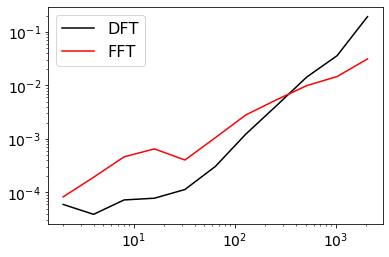

In [7]:
plt.loglog(2**np.arange(1,pf),np.array(dft_time), 'k-', 2**np.arange(1,pf),np.array(fft_time), 'r-')
plt.legend(('DFT','FFT'), fontsize = 16)

Although FFT is more efficient for large sizes, for relatively small sizes DFT appears to be more efficient. Partly this because the matrix-multiplication is written in Fortran, whereas our FFT is written in pure Python.

In [8]:
from time import time

fft_time = []
nruns = 3
pf = 15
for p in range(1,pf):
    x = np.random.random(2**p)
    #Time FFT
    t2 = 0
    for j in range(nruns):
        t1 = time()
        y = FFT(x)
        t2 += time()-t1
    
    fft_time.append(t2/nruns)



### Timing and cost of FFT

The cost of FFT scales as $\sim n\log_2n$. This can be seen even in the naive implementation.

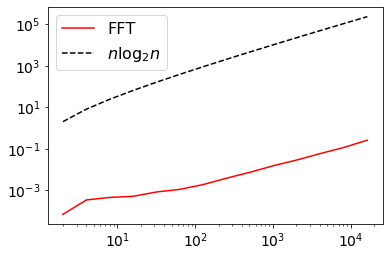

In [9]:
N = 2**np.arange(1,pf)
plt.loglog( N,np.array(fft_time), 'r-', N, N*np.log2(N), 'k--')
plt.legend(('FFT', '$n\log_2 n$'), fontsize = 16)

### Informal analysis of computational cost


Let $n= 2^p$. 
+ There are $p = \log_2(n)+ 1$ levels of recursion. 
+ At the lowest level, there are $n = 2^p$ DFTs of size $1$. This costs $\mathcal{O}(n)$ flops.
+ One level higher, we have to work with $n/2 = 2^{p-1}$ vectors of size $2$ each. This costs $\mathcal{O}(n)$ flops.
+ ...
+ At the highest level we have to work with $2$ vectors of size $n/2 = 2^{p-1}$ each. This costs $\mathcal{O}(n)$ flops.

Therefore, total costs are 
$$ \text{Cost} =  \underbrace{\mathcal{O}(n) +  \mathcal{O}(\frac{n}{2}  \cdot 2  ) + \dots + \mathcal{O}(2 \cdot \frac{n}{2})}_\text{p terms } = \mathcal{O}(n\log_2(n)) \text{ flops}.  $$ 

## FFT as a factorization

### Towards matrix-vector formulation

Let $f_\text{even} = [f_0, \dots, f_{n-2}]^T$ and $f_\text{odd} = [f_1,\dots,f_{n-1}]^T$. Then we can write 

$$ \begin{aligned} y_{1:\frac{n}{2}} = & \>  F_{\frac{n}{2}} f_\text{even} + \Omega_{\frac{n}{2}} F_{\frac{n}{2}}f_\text{odd} \\
y_{\frac{n}{2}+1:n} = & \>  F_{\frac{n}{2}} f_{even} - \Omega_{\frac{n}{2}} F_{\frac{n}{2}}  f_\text{odd} \end{aligned}$$

where 

+ $F_n$ is the Fourier matrix (note new convention)

$$[F_n]_{jk} = \omega_n^{(j-1)(k-1)} \qquad j,k=1,\dots,n$$ 

+ $\Omega_{\frac{n}{2}} = \text{diag}(1,\omega_n, \dots, \omega_n^{\frac{n}{2}-1})$.

### Factorization of the Fourier Matrix 

We can write 
$$ F_n \Pi_n = \begin{bmatrix} F_{\frac{n}{2}} & \Omega_{\frac{n}{2}} F_{\frac{n}{2}} \\
F_{\frac{n}{2}} & -\Omega_{\frac{n}{2}} F_{\frac{n}{2}}   \end{bmatrix}, $$

where $\Pi_n$ is the even-odd shuffle permutation.

### Recursive factorization of the Fourier matrix
Once again, let $n=2^p$. Then 
$$ F_n = A_p \dots A_1 P_n.$$

+ The matrices $A_q$ have the form
$$ A_q = \text{diag}(\underbrace{B_L,\dots,B_L}_\text{r terms}) \qquad B_L = \begin{bmatrix} I & \Omega_{\frac{L}{2}}  \\ I & - \Omega_{\frac{L}{2}}   \end{bmatrix}  \qquad  L = 2^q, r = n/L, $$ 
+ $P_n$ is a bit-reversal matrix. 

The matrices $A_q$ are sparse, so a careful implementation can be done in $5n\log_2(n)$ flops. 

## Shuffle permutation

### Bit-reversal and shuffle permutation
Consider $n = 2^3 = 8$. The structure of the operations is 
+ $\{0,1,2,3,4,5,6,7\}$
+ $\{0,2,4,6\}$ and $\{1,3,5,7\}$
+ $\{0,4\}$, $\{2,6\}$, $\{1,5\}$ and $\{3,7\}$
+ $\{0\}$, $\{4\}$, $\{2\}$, $\{6\}$, $\{1\}$, $\{5\}$, $\{3\}$, and $\{7\}$   

This last sequence can be generated very efficiently using the idea of bit reversal.

### Recall binary representation


In general, any nonnegative integer less than $2^p$ has the binary representation
$$ b_{p-1} 2^{p-1} +  \dots + b_12^{1} + b_02^0 = (b_{p-1}\dots b_{0})_2. $$ 


For example, if $n=2^3 = 8$, we can represent $5$ in binary as 
$$ 5 = 1\cdot 2^2 + 0\cdot 2^1 + 1\cdot 2^0 = (101)_2.$$


### Binary representation and the shuffle permutation

| Number | Binary representation | Bit reversed | Number |
| --- | ----------- | ----------- | ----------- | 
0 | 000 | 000 | 0 |
1 | 001 | 100 | 4| 
2 | 010 | 010 | 2| 
3 | 011 | 110 | 6 | 
4 | 100 | 001 | 1 | 
5 | 101 | 101 | 5 |
6 | 110 | 011 | 3 |
7 | 111 | 111 | 7| 

By reversing the bits we get an efficient way of permutating the entries in a way to implement the FFT algorithm.

### General cases and extensions

+ It is not uncommon to pick $2^p$ for computational convenience. 
+ A modern FFT code can handle the case when $n \neq 2^p$. 
+ The case when $N = r_1\dots r_p$ is explained in Dahlquist and Bjorck, Section 4.7.
+ There are also fast algorithms for non-uniformly spaced FFT. 

Reading/References:
+ Van Loan. Computational frameworks for the fast Fourier transform. SIAM, 1992.
+ Dahlquist and Bjorck. Numerical Methods in Scientific Computing: Volume 1: SIAM, 2008.
+ van der Plas. Understanding the FFT Algorithm. [notebook](https://nbviewer.jupyter.org/url/jakevdp.github.io/downloads/notebooks/UnderstandingTheFFT.ipynb).